In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
/kaggle/input/mercari-price-suggestion-challenge/test.tsv.7z
/kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
/kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip
/kaggle/input/mercari-price-suggestion-challenge/sample_submission.csv.7z


In [2]:
!pip install pyunpack
!pip install patool

import os
from pyunpack import Archive
import shutil
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 2.6 MB/s eta 0:00:00


In [3]:
# 解凍したいファイルのフルパス
TRAIN_PACKED_PATH="/kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z"
TEST_PACKED_PATH="/kaggle/input/mercari-price-suggestion-challenge/test.tsv.7z"

# 解凍後のファイルの出力先
UNPACKED_PATH="/kaggle/working/unlocked/"

if not os.path.exists(UNPACKED_PATH):
    os.makedirs(UNPACKED_PATH)
    
Archive(TRAIN_PACKED_PATH).extractall(UNPACKED_PATH)
Archive(TEST_PACKED_PATH).extractall(UNPACKED_PATH)

for dirname, _, filenames in os.walk(TEST_PACKED_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk(TRAIN_PACKED_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
path = "/kaggle/working/unlocked/"
train_df = pd.read_csv(path+"train.tsv", header=0, sep='\t')
test_df = pd.read_csv(path+"test.tsv", header=0, sep='\t')

print(train_df.shape)
print(test_df.shape)

(1482535, 8)
(693359, 7)


# priceが今回の目的変数であることを確認

**name：商品のタイトル(価格データなどは削除してあります)<br>
item_condition_id：商品のコンディション<br>
category_name：商品のカテゴリ (最大3つ)<br>
brand_name：ブランド名<br>
price：商品が販売された時の価格(ドル)で、今回求める数値<br>
shipping：送料が出品者負担かどうか(出品者負担: 1、購入者負担: 0)<br>
item_description：商品の説明、価格情報は削除済み**

In [5]:
train_df.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [6]:
test_df.head(3)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...


# priceの分布を確認し、歪度が0から離れていれば自然対数変換で正規分布に近づける

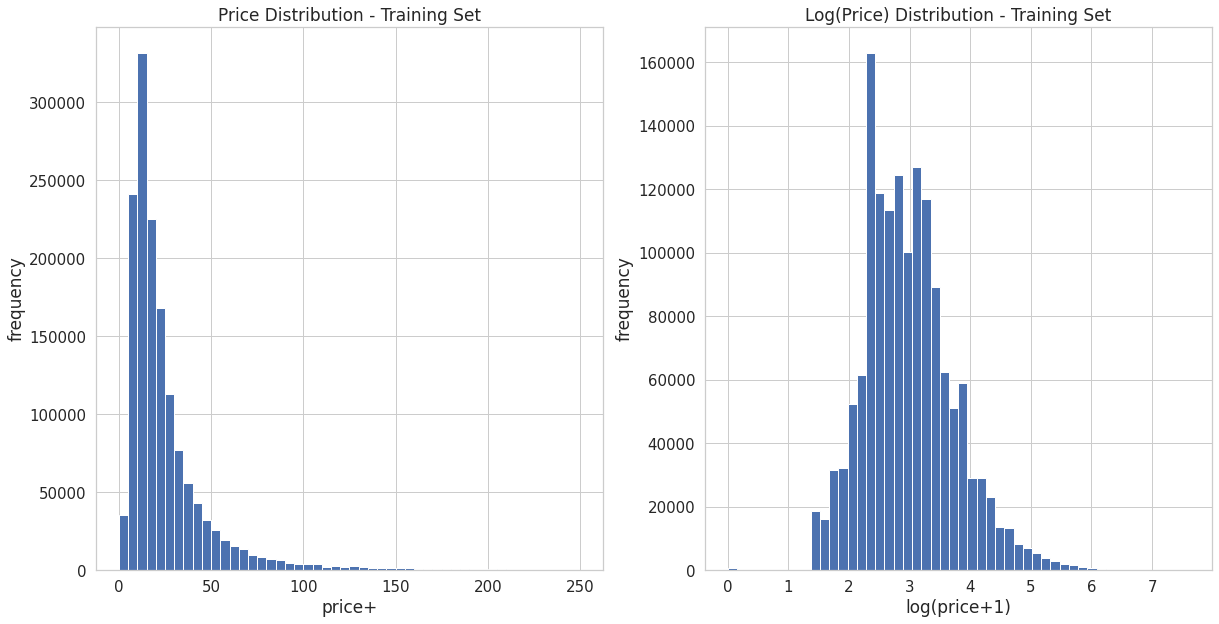

In [7]:
plt.subplot(1, 2, 1) # 表の配置
(train_df['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

plt.subplot(1, 2, 2)
np.log1p(train_df['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

In [8]:
train_df['price'] = np.log1p(train_df['price'])

# 欠損値の補完

In [9]:
train_df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [10]:
train_df['category_name'] = train_df['category_name'].fillna("Nan")
train_df['brand_name'] = train_df['brand_name'].fillna("Nan")
train_df['item_description'] = train_df['item_description'].fillna("Nan")
test_df['category_name'] = test_df['category_name'].fillna("Nan")
test_df['brand_name'] = test_df['brand_name'].fillna("Nan")
test_df['item_description'] = test_df['item_description'].fillna("Nan")

In [11]:
train_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

In [12]:
type(test_df['category_name'][0])

str

In [13]:
try:
    train_category_name_list = []
    for categorys_name in train_df['category_name']:
        category_names = categorys_name.split('/')
        train_category_name_list.append(category_names)
except Exception as e:
    print(categorys_name)
    print(e)
        
test_category_name_list = []
for categorys_name in test_df['category_name']:
    category_names = categorys_name.split('/')
    test_category_name_list.append(category_names)

In [14]:
len(test_category_name_list)

693359

In [15]:
len(train_category_name_list)

1482535

In [16]:
train_category_name_list = pd.DataFrame(train_category_name_list)
test_category_name_list = pd.DataFrame(test_category_name_list)

train_df['category_0'] = train_category_name_list[0]
train_df['category_1'] = train_category_name_list[1]
train_df['category_2'] = train_category_name_list[2]

test_df['category_0'] = test_category_name_list[0]
test_df['category_1'] = test_category_name_list[1]
test_df['category_2'] = test_category_name_list[2]

In [17]:
train_df['category_0'].head()

0            Men
1    Electronics
2          Women
3           Home
4          Women
Name: category_0, dtype: object

In [18]:
train_df['category_1'] = train_df['category_1'].fillna("Nan")
train_df['category_2'] = train_df['category_2'].fillna("Nan")
test_df['category_1'] = test_df['category_1'].fillna("Nan")
test_df['category_2'] = test_df['category_2'].fillna("Nan")

# factorize：配列のユニークな文字にそれぞれ数値の1からラベルを割振る

In [19]:
train_df['name'], _ = pd.factorize(train_df['name'])
train_df['brand_name'], _ = pd.factorize(train_df['brand_name'])
train_df['category_0'], _ = pd.factorize(train_df['category_0'])
train_df['category_1'], _ = pd.factorize(train_df['category_1'])
train_df['category_2'], _ = pd.factorize(train_df['category_2'])

test_df['name'], _ = pd.factorize(test_df['name'])
test_df['brand_name'], _ = pd.factorize(test_df['brand_name'])
test_df['category_0'], _ = pd.factorize(test_df['category_0'])
test_df['category_1'], _ = pd.factorize(test_df['category_1'])
test_df['category_2'], _ = pd.factorize(test_df['category_2'])

# 不要なカラムの削除

In [20]:
train_df.drop(['train_id', 'category_name', 'item_description'], axis=1, inplace=True)
test_df.drop(['test_id', 'category_name', 'item_description'], axis=1, inplace=True)

In [21]:
train_df.head()

,name,item_condition_id,brand_name,price,shipping,category_0,category_1,category_2
0,0,3,0,2.397895,1,0,0,0
1,1,3,1,3.970292,0,1,1,1
2,2,1,2,2.397895,1,2,2,2
3,3,1,0,3.583519,1,3,3,3
4,4,1,0,3.806662,0,2,4,4


In [22]:
test_df.head()

,name,item_condition_id,brand_name,shipping,category_0,category_1,category_2
0,0,1,0,1,0,0,0
1,1,1,0,1,1,1,1
2,2,1,1,1,2,2,2
3,3,2,0,0,0,3,3
4,4,3,0,1,1,4,4


In [23]:
train_df.isnull().sum()

name                 0
item_condition_id    0
brand_name           0
price                0
shipping             0
category_0           0
category_1           0
category_2           0
dtype: int64

In [24]:
test_df.isnull().sum()

name                 0
item_condition_id    0
brand_name           0
shipping             0
category_0           0
category_1           0
category_2           0
dtype: int64